# Backprop своими руками

Материалы:

* [Andrew Karpahy: yes, you should understand backprop](https://medium.com/@karpathy/yes-you-should-understand-backprop-e2f06eab496b)
* [Stanford CS231n](http://cs231n.stanford.edu/)
* [Deep Learning](http://sereja.me/f/deep_learning_goodfellow.pdf) — с 204 страницы и до прозрения
* [Xavier, Bengio](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf)

<img width='800px' src='https://cdn-images-1.medium.com/max/1600/1*q1M7LGiDTirwU-4LcFq7_Q.png'>

Иногда сети пишут на чистом C++, причём код для обучения и инференса (реального прогона в продакшне) — отдельно. Так делают, когда нужен очень быстрый отклик и высокая производительность, но это очень трудоемко.

Большинство людей не усложняют себе жизнь и просто используют фреймворки — с ними можно просто почти декларативно описать, какие операции хотите сделать с данными, а он потом сам построит сеть и подгонит её под данные.

Ваше задание — реализовать свой небольшой фреймворк глубокого обучения на чистом `numpy`. Основное время у вас должно уйти на вывод формул для градиентов, анализ поведения самых часто используемых слоев в современных нейросетях и прочий матан. Хотя бы один раз в жизни это надо сделать, а уже потом пользоваться готовыми абстракциями.

Предполагаемый порядок выполнения:
* Поймите на высоком уровне, как работает алгоритм backpropagation
* Изучите пример с логиситической регрессией, чтобы понять, что от вас в итоге хотят
* Изучите код `Module`
* `Sequential`
* `Linear`
* `SoftMax`
* `CrossEntropy`
* Протестируйте их на логистической регрессии
* Напишите код для решения MNIST
* Дописывайте остальные слои, пока не получите на нём 97%

Оценивание (суммарно до 20 баллов):
* 5 баллов -- что-то хоть как-то обучается, MNIST на валидации >90%
* 2 балла -- MNIST на 95%, дальше по одному баллу за 96%, 97% и 98%. Это будет сделать намного сложнее, чем через PyTorch, потому что вам всё нужно писать самим: более сложные оптимизаторы, learning rate decay, думать про численную стабильность и т. д.
* По 2 балла за слои: LeakyReLU, Dropout, BatchNorm, CrossEntropy, SoftMax

Советы:
* Чтобы лучше понять, что должно в итоге получиться, изучите «игрушечный пример» и вообще эту тетрадку, а потом начните читать `hw_framework.py`, где будет более техничное описание.
* Для дебага проверяйте градиенты численно — сдвигайте параметры на какой-нибудь эпсилон и смотрите разницу. Ещё можете проверить, что на одинаковых данных они дают то же, что их эквиваленты из PyTorch (можно после каждого нового слоя добавить юнит тест через `assert`).
* Пишите код без циклов — в питоне они очень долгие; все вычисления можно делать внутри numpy.
* Ограничение на срок сдачи большое — до конца всего курса, но рекомендуется закончить примерно за месяц. Дописывайте его постепенно, разбираясь, как работает каждая функция активации.
* Обсуждайте математику и общую архитектуру фреймворка, но не шарьте друг другу код — так не интересно.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.simplefilter('ignore')

---

Откройте в Jupyter две тетрадки — эту и `hw_framework.ipynb`. В этой содержится train loop, а там непосредственно ваш «фреймворк», который вам ещё предстоит написать.

Архитектура фреймворка вдохновлена PyTorch. Как всегда, если придумаете какой-то более клёвый дизайн — можете использовать его.

In [2]:
%run hw_framework.ipynb

Wall time: 44 ms
Wall time: 4 ms


Мы будем использовать самый простой вариант градиентного спуска: просто пройдемся по всем параметрам и сделаем шаги в сторону уменьшения посчитанного заранее градиента.

Есть [более продвинутые методы](http://ruder.io/optimizing-gradient-descent/), но пока что мы их использовать не будем.

In [3]:
def SGD(params, gradients, lr=1e-3):    
    for weights, gradient in zip(params, gradients):
        #print(type(lr), type(gradient))
        #print(weights.shape, gradient.shape)
        weights -= lr * gradient

Cоздадим обертку вокруг нашего датасета (просто numpy-евские массивы), которую будем потом использовать, чтобы итерироваться по нему.

In [4]:
def loader(X, Y, batch_size):    
    n = X.shape[0]

    # в начале каждой эпохи будем всё перемешивать
    # важно, что мы пермешиваем индексы, а не X
    indices = np.arange(n)
    np.random.shuffle(indices)
    
    for start in range(0, n, batch_size):
        # в конце нам, возможно, нужно взять неполный батч
        end = min(start + batch_size, n)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

В следующих двух секциях — игрушечные примеры регрессии и классификации на синтезированных данных. В них ничего менять не надо — они нужны, чтобы отдебажить ваши слои в `hw_framework`.

# Линейная регрессия

In [5]:
n = 1000

X = np.random.randn(n, 10)
true_w = np.random.randn(10, 1)
Y = np.dot(X, true_w).reshape(n, 1) + np.random.randn(n, 1) / 5

print('best_possible_mse:', np.mean(np.power(Y-np.dot(X, true_w).reshape(n), 2)))

best_possible_mse: 26.35018363798124


### Модель

In [6]:
model = Sequential(
    Linear(10, 1),
)

criterion = MSE()

Можете тут потом тестировать остальные свои слои, когда их напишите.

### Обучение

In [7]:
epochs = 10
batch_size = 10
learning_rate = 1e-1

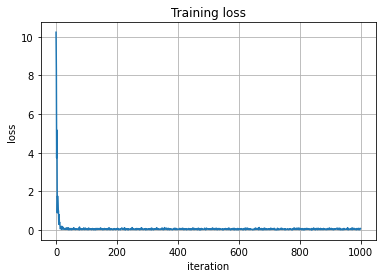

In [8]:
history = []

for i in range(epochs):
    for x, y_true in loader(X, Y, batch_size):
        # forward -- считаем все значения до функции потерь
        y_pred = model.forward(x)
        loss = criterion.forward(y_pred, y_true)

        #print(y_pred, y_true)
        #print('SUM OF SQUARES:', np.mean(np.power(y_pred-y_true, 2)))
    
        # backward -- считаем все градиенты в обратном порядке
        grad = criterion.backward(y_pred, y_true)
        
        model.backward(x, grad)
        
        # обновляем веса
        SGD(model.parameters(),
            model.grad_parameters(),
            learning_rate)
        
        #print(model.layers[0].W[0][0])
        #print(loss)
        
        history.append(loss)

    
plt.title("Training loss")
plt.xlabel("iteration")
plt.ylabel("loss")
plt.plot(history)
plt.grid()
plt.show()

# Логистическая регрессия

Этот пример нужнен для теситрования классификации (`CrossEntropy` и `SoftMax`).

Возьмем в качестве датасета точки из двух гауссиан на плоскости.

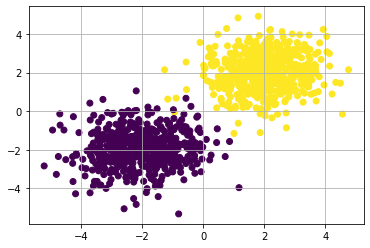

In [9]:
n = 500

X1 = np.random.randn(n, 2) + np.array([2, 2])
X2 = np.random.randn(n, 2) + np.array([-2, -2])
X = np.vstack([X1, X2])

Y = np.concatenate([np.ones(n), np.zeros(n)])[:, None]
Y = np.hstack([Y, 1-Y])

plt.scatter(X[:,0], X[:,1], c=Y[:,0])
plt.grid()
plt.show()

Обратите внимание на `y`. Он в формате one-hot: у каждого вектора все нули, кроме одной единицы.

Выходные данные в таком формате упростят написание `CrossEntropy`.

### Модель

Логистическая регрессия — это тоже как бы маленькая нейронка: линейный слой, софтмакс, и максимизируем правдоподобие.

In [10]:
model = Sequential(
    Linear(2, 2),
    SoftMax()
)

criterion = CrossEntropy()

### Обучение

In [11]:
epochs = 100
batch_size = 16
learning_rate = 1e-1

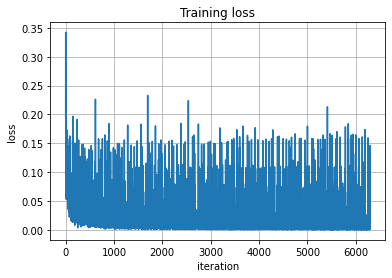

In [12]:
history = []

for i in range(epochs):
    for x, y_true in loader(X, Y, batch_size):
        # forward: считаем все значения до функции потерь
        y_pred = model.forward(x)
        #print(y_pred, y_true),
        loss = criterion.forward(y_pred, y_true)
        
        # backward: считаем все градиенты в обратном порядке
        grad = criterion.backward(y_pred, y_true)
        #print(grad)
        model.backward(x, grad)
        
        # обновляем веса
        SGD(model.parameters(),
            model.grad_parameters(),
            learning_rate)
        
        #print(loss)
        # логгируем лосс
        history.append(loss)


plt.title("Training loss")
plt.xlabel("iteration")
plt.ylabel("loss")
plt.plot(history)
plt.grid()
plt.show()

Мы тут пропустили много важных деталей: валидация, подсчет точности (кроссэнтропия не очень информативна), регуляризация. Вам всё это нужно будет реализовать потом самим.

# Теперь сами

In [13]:
import pandas as pd
from sklearn.model_selection import train_test_split
X = pd.read_csv('train.csv')
y = pd.get_dummies(X['label'])
X = X.drop(['label'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(np.array(X), np.array(y), test_size=0.33, random_state=42)

In [14]:
def accuracy(model, val):
    total, correct = 0, 0
    for x, y in val:
        res = model.forward(x)
        res = np.argmax(res, axis=1)
        y = np.argmax(y, axis=1)
        total += res.shape[0]
        correct += np.sum(res == y)
    return correct / total

In [15]:
model = Sequential(
    Linear(784, 128),
    ReLU(),
    Linear(128, 64),
    ReLU(),
    Linear(64, 10),
    SoftMax()
)

criterion = CrossEntropy()

In [16]:
NUM_EPOCH = 20
BATCH_SIZE = 64
LEARNING_RATE = 2e-2

In [17]:
history = []
train_accuracy = []
test_accuracy = []

for i in range(NUM_EPOCH):
    for x, y_true in loader(X_train, y_train, BATCH_SIZE):
        y_pred = model.forward(x)
        loss = criterion.forward(y_pred, y_true)

        grad = criterion.backward(y_pred, y_true)
        model.backward(x, grad)
        
        SGD(model.parameters(),
            model.grad_parameters(),
            LEARNING_RATE)
        
        history.append(loss)
    
    q1 = accuracy(model, loader(X_train, y_train, BATCH_SIZE))
    q2 = accuracy(model, loader(X_test, y_test, BATCH_SIZE))
    
    train_accuracy.append(q1)
    test_accuracy.append(q2)
    
    print('Train accuracy:', q1)
    print('Test accuracy:', q2)
    print('--' * 15)

Train accuracy: 0.917590618336887
Test accuracy: 0.9101731601731602
------------------------------
Train accuracy: 0.9339729921819474
Test accuracy: 0.9213564213564214
------------------------------
Train accuracy: 0.9550106609808102
Test accuracy: 0.9409090909090909
------------------------------
Train accuracy: 0.9648542999289268
Test accuracy: 0.9477633477633478
------------------------------
Train accuracy: 0.9694385216773277
Test accuracy: 0.9489177489177489
------------------------------
Train accuracy: 0.9734186211798153
Test accuracy: 0.9565656565656566
------------------------------
Train accuracy: 0.9786425017768301
Test accuracy: 0.9584415584415584
------------------------------
Train accuracy: 0.9780383795309169
Test accuracy: 0.9545454545454546
------------------------------
Train accuracy: 0.9824804548685145
Test accuracy: 0.9602453102453102
------------------------------
Train accuracy: 0.9832977967306326
Test accuracy: 0.9592352092352092
------------------------------
T

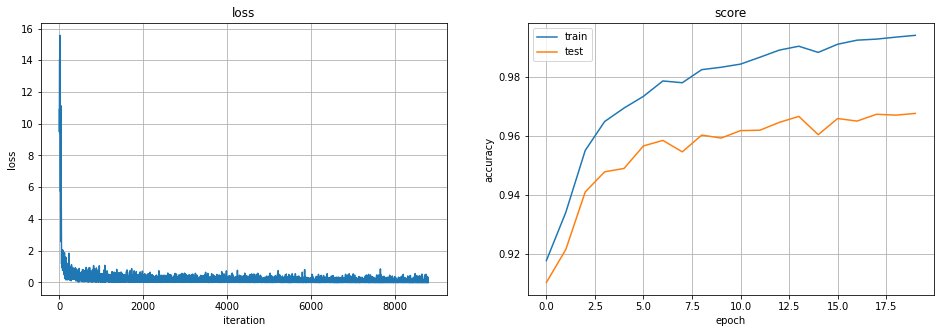

In [18]:
plt.figure(figsize=(16, 5))

plt.subplot(121)
plt.title('loss')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.plot(history)
plt.grid()

plt.subplot(122)
plt.plot(train_accuracy, label='train')
plt.plot(test_accuracy, label='test')
plt.title('score')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.grid()

In [19]:
print('Best score on test:', np.max(test_accuracy))

Best score on test: 0.9676046176046176


Теперь напишите модель и train loop. Можете начать с адаптации предыдущего примера.

Дальше начинается творческая часть и настоящий Deep Learning:
* поиграйтесь с архитектурами;
* поиграйтесь с learning rate и batch_size;
* сделайте learning rate decay;
* сделайте data augmentation.

Have fun. Дедлайн — не две недели, а до конца курса.